Most of the core algorithmic stuff is packaged into _SDOptimizer_. We instantiate an object and then load in the data from a single smoke source which was obtained from Katie's simulation. This represents the smoke consentation at a point on the wall at a certain time. 

In [1]:
import numpy as np
import SDOptimizer as SDOmodule
from SDOptimizer.SDOptimizer import SDOptimizer
import matplotlib as plt
#import importlib

#importlib.reload(SDOmodule)
plt.rcParams["figure.figsize"] = (10, 7)
DATA_FILE = "exportUSLab.csv"  # Points to the data Katie gave us
DATA_DIR = "data/data 2-19-10-20200329T152004Z-001" # this data was emailed around

SDO = SDOptimizer()

In [2]:
#SDO.visualize(show=False, log=True)

What we really want to extract from the data is the minimum time to alarm at any location on the wall. _SDOptimizer.get\_time\_to\_alarm()_ takes the most-recently loaded data and returns this information. The data can be optionally flipped about the x or y axis to provide augmented data for testing, since we only have one smoke source. You can also select which one to visualize. Furthermore, you can add infeasible locations where it is impossible to place a detector.

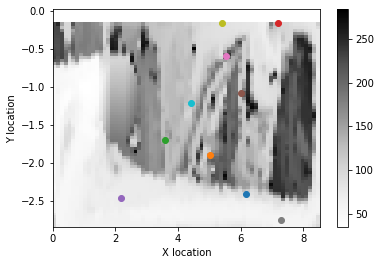

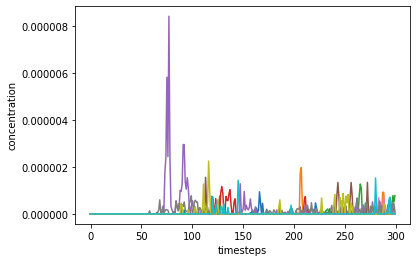

In [3]:
SDO.load_timestep_directory(DATA_DIR)
source1 = SDO.get_time_to_alarm(False, False) # the default value of flip is false, so this is simply included for clarity
source2 = SDO.get_time_to_alarm(True, False) # flip about the x axis
source3 = SDO.get_time_to_alarm(False, True) # flip about the x axis
source4 = SDO.get_time_to_alarm(False, False, visualize=True) # flip about both axis 
smoke_sources = [source1, source2, source3, source4]

In [4]:
#SDO.load_data(DATA_FILE)
#Y_SHIFT = -3
#bad_source1 = SDO.get_time_to_alarm(False, False, y_shift=Y_SHIFT) # the default value of flip is false, so this is simply included for clarity
#bad_source2 = SDO.get_time_to_alarm(True, False, y_shift=Y_SHIFT) # flip about the x axis
#bad_source3 = SDO.get_time_to_alarm(False, True,  y_shift=Y_SHIFT) # flip about the x axis
#bad_source4 = SDO.get_time_to_alarm(False, False,  y_shift=Y_SHIFT, visualize=True) # flip about both axis 
#bad_smoke_sources = [bad_source1, bad_source2, bad_source3, bad_source4]

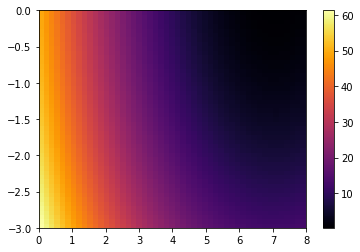

In [5]:
X_BOUNDS = [0, 8]
Y_BOUNDS = [-3, 0]
CENTERS = [2,-1.5, 4, -3, 7, 0.5]
example1 = SDO.example_time_to_alarm(X_BOUNDS, Y_BOUNDS, CENTERS[:2]) 
example2 = SDO.example_time_to_alarm(X_BOUNDS, Y_BOUNDS, CENTERS[2:4]) 
example3 = SDO.example_time_to_alarm(X_BOUNDS, Y_BOUNDS, CENTERS[4:], show=True) # show
bad_smoke_sources = [example1, example2, example3]

Rather than loading from one data file, you can also load all of the files from one directory. No augmentation will be performed. 

In [6]:
#sources = SDO.load_directory("data")

Now, we generate our objective function from this data. This function maps from the locations of all smoke detectors, to the worst-case time to alarm. This is done by finding, for each smoke source, the minimum time to alarm for any detector, and then taking the largest value, representing the worst-case smoke source. This was formalized in notes I sent in an email a while ago.

The behavior of the objective function can be somewhat visualized by fixing the location of _n_ smoke detectors and then sweeping the last one. Each smoke source is also shown.

min x : 0.0, max x : 8.539999962000001, min y : -2.84649992, max y : -0.15350000560000002


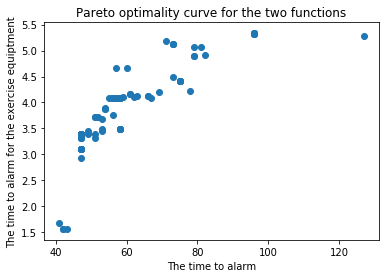

the result of the optimization is:


/home/david/dev/SmokeDetectorOptimization/SDOptimizer/SDOptimizer.py:710: UserWarning: Can't visualize the objective values for a multiobjective run
  UserWarning)


In [7]:
description = SDO.optimize(smoke_sources, 3, genetic=True, platypus=True, multiobjective_type="competing_function", bad_sources=bad_smoke_sources, visualize=True, type="worst_case")

print("the result of the optimization is:\n {}".format(description))

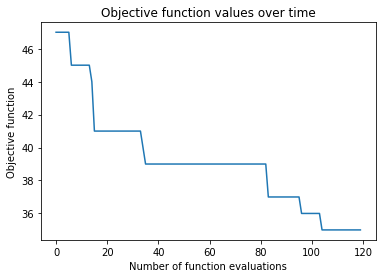

<Figure size 432x288 with 0 Axes>

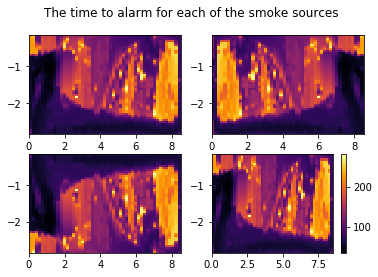

<Figure size 432x288 with 0 Axes>

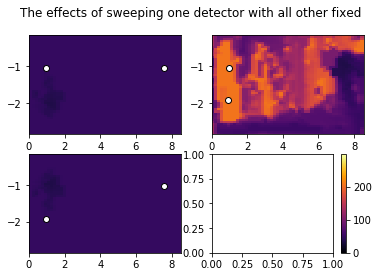

The bounds are now [(0.0, 8.539999962000001), (-2.84649992, -0.15350000560000002), (0.0, 8.539999962000001), (-2.84649992, -0.15350000560000002), (0.0, 8.539999962000001), (-2.84649992, -0.15350000560000002)]
The locations are: (0.944, -1.925), (7.606, -1.034), (0.978, -1.050), 
the result of the optimization is:
      fun: 35.0
 message: 'Optimization terminated successfully.'
    nfev: 10897
     nit: 120
 success: True
       x: array([ 0.94372231, -1.92465591,  7.60615969, -1.03435034,  0.97794424,
       -1.04958492])


In [8]:
smoke_sources = [source1, source2, source3, source4]
bounds =  [0, 8.1, -3, 0]
initialization = [1.70799994, 1.89999998, 6.83200002, 1.89999998, 1.9, 1.4]
description = SDO.optimize(smoke_sources, 3, genetic=True, platypus=False, masked=True, visualize=True, type="worst_case")

print("the result of the optimization is:\n {}".format(description))

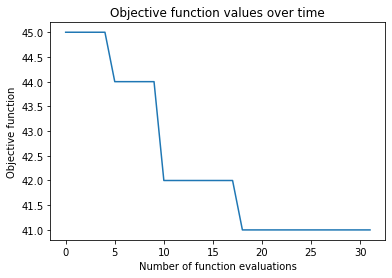

<Figure size 432x288 with 0 Axes>

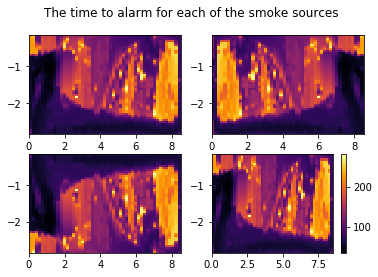

<Figure size 432x288 with 0 Axes>

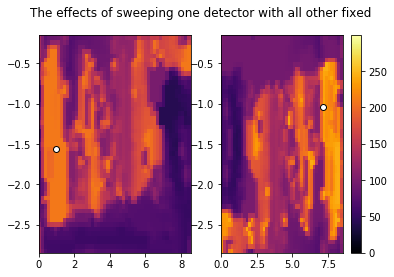

The bounds are now [(0.0, 8.539999962000001), (-2.84649992, -0.15350000560000002), (0.0, 8.539999962000001), (-2.84649992, -0.15350000560000002)]
The locations are: (7.116, -1.045), (0.988, -1.563), 
the result of the optimization is:
      fun: 41.0
 message: 'Optimization terminated successfully.'
    nfev: 1985
     nit: 32
 success: True
       x: array([ 7.11585615, -1.04523507,  0.98838943, -1.56290002])


In [9]:
# running with two detectors
description = SDO.optimize(smoke_sources, 2, genetic=True)
print("the result of the optimization is:\n {}".format(description))

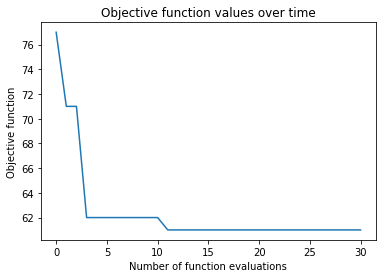

<Figure size 432x288 with 0 Axes>

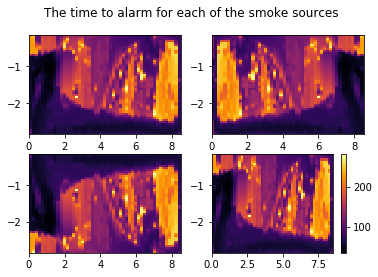

<Figure size 432x288 with 0 Axes>

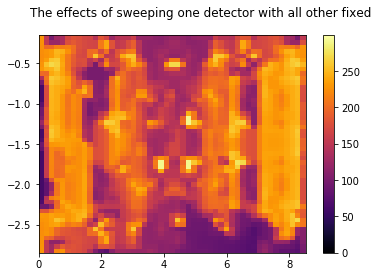

The bounds are now [(0.0, 8.539999962000001), (-2.84649992, -0.15350000560000002)]
The locations are: (0.004, -1.601), 
the result of the optimization is:
      fun: 60.99999999999999
 message: 'Optimization terminated successfully.'
    nfev: 963
     nit: 31
 success: True
       x: array([ 0.0039302 , -1.60143603])


In [10]:
# running with one detector
description = SDO.optimize(smoke_sources, 1, genetic=True)
print("the result of the optimization is:\n {}".format(description))

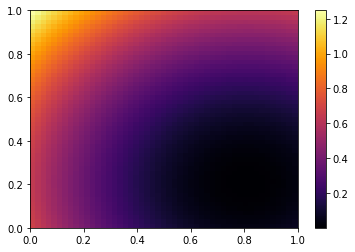

In [11]:
X_BOUNDS = [0, 1]
Y_BOUNDS = [0, 1]
CENTERS = [0.2, 0.8, 0.8, 0.8, 0.8, 0.2]
example1 = SDO.example_time_to_alarm(X_BOUNDS, Y_BOUNDS, CENTERS[:2]) 
example2 = SDO.example_time_to_alarm(X_BOUNDS, Y_BOUNDS, CENTERS[2:4]) 
example3 = SDO.example_time_to_alarm(X_BOUNDS, Y_BOUNDS, CENTERS[4:], show=True) # show

To debug, you can also ues example data drawn from a quadratic. 

Add some noise to the optimal locations which are the centers

[0.22766358 0.68261299 0.8137394  0.70043351 0.75360569 0.05174638]


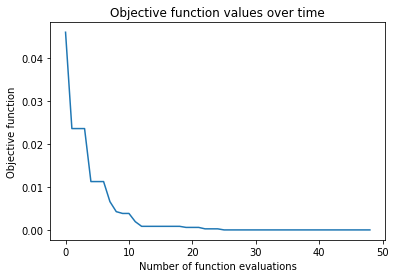

<Figure size 432x288 with 0 Axes>

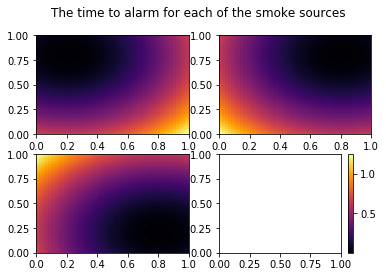

<Figure size 432x288 with 0 Axes>

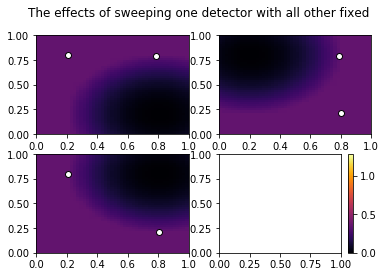

The bounds are now [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
The locations are: (0.803, 0.210), (0.206, 0.799), (0.788, 0.794), 
the result of the optimization is:
      fun: 3.331945022907383e-05
 message: 'Optimization terminated successfully.'
    nfev: 4507
     nit: 49
 success: True
       x: array([0.80288792, 0.21030846, 0.20632481, 0.79936498, 0.78786965,
       0.79394345])


In [12]:
example_sources = [example1, example2, example3]
bounds =  [0,1,0,1]
NOISE_SCALE = 0.1
initialization = CENTERS + np.random.normal(scale=NOISE_SCALE, size=(len(CENTERS)))
print(initialization)
description = SDO.optimize(example_sources, 3, bounds=bounds, initialization=initialization)
print("the result of the optimization is:\n {}".format(description))